Last updated 24/10/2024 [Ref.](https://huggingface.co/docs/transformers/tasks/zero_shot_image_classification)

In [ ]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00


# Zero-shot image classification

Zero-shot image classification is a task that involves classifying images into different categories using a model that was
not explicitly trained on data containing labeled examples from those specific categories.

Traditionally, image classification requires training a model on a specific set of labeled images, and this model learns to
"map" certain image features to labels. When there's a need to use such model for a classification task that introduces a
new set of labels, fine-tuning is required to "recalibrate" the model.

In contrast, zero-shot or open vocabulary image classification models are typically multi-modal models that have been trained on a large
dataset of images and associated descriptions. These models learn aligned vision-language representations that can be used for many downstream tasks including zero-shot image classification.

This is a more flexible approach to image classification that allows models to generalize to new and unseen categories
without the need for additional training data and enables users to query images with free-form text descriptions of their target objects .

In this guide you'll learn how to:

* create a zero-shot image classification pipeline
* run zero-shot image classification inference by hand

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q transformers
```

## Zero-shot image classification pipeline

The simplest way to try out inference with a model supporting zero-shot image classification is to use the corresponding [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline).
Instantiate a pipeline from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads):

In [ ]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
classifier = pipeline(model=checkpoint, task="zero-shot-image-classification")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Next, choose an image you'd like to classify.

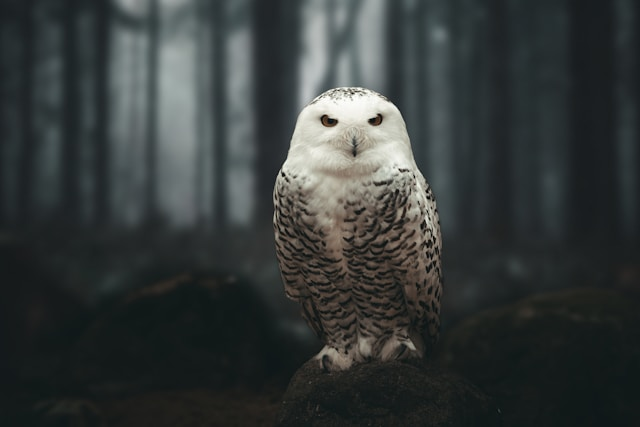

In [ ]:
from PIL import Image
import urllib.request
url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
urllib.request.urlretrieve(url,"owl.jpg")
image = Image.open("owl.jpg")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/owl.jpg" alt="Photo of an owl"/>
</div>

Pass the image and the candidate object labels to the pipeline. Here we pass the image directly; other suitable options
include a local path to an image or an image url.
The candidate labels can be simple words like in this example, or more descriptive.

In [ ]:
predictions = classifier(image, candidate_labels=["fox", "bear", "seagull", "owl"])
predictions

[{'score': 0.9992450475692749, 'label': 'owl'},
 {'score': 0.0005944140139035881, 'label': 'seagull'},
 {'score': 8.649088704260066e-05, 'label': 'fox'},
 {'score': 7.409247336909175e-05, 'label': 'bear'}]

## Zero-shot image classification by hand

Now that you've seen how to use the zero-shot image classification pipeline, let's take a look how you can run zero-shot
image classification manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads).
Here we'll use the same checkpoint as before:

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Let's take a different image to switch things up.

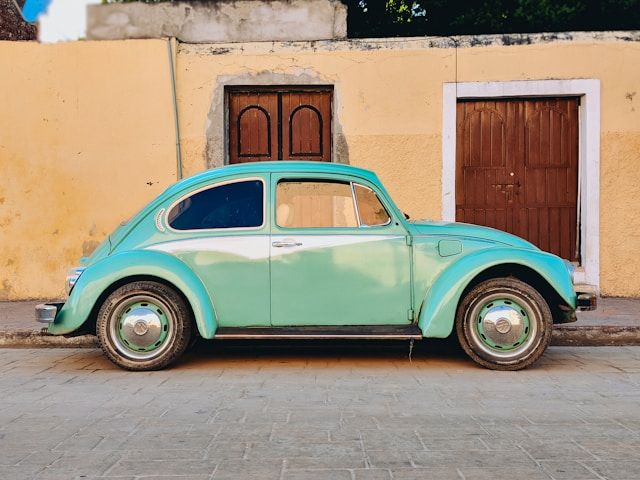

In [ ]:
from PIL import Image
import urllib.request

url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
urllib.request.urlretrieve(url,"car.jpg")
image = Image.open("car.jpg")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg" alt="Photo of a car"/>
</div>

Use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the
image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [ ]:
candidate_labels = ["tree", "car", "bike", "cat"]
inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

Pass the inputs through the model, and post-process the results:

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.9988661, 'label': 'car'},
 {'score': 0.0008380688, 'label': 'bike'},
 {'score': 0.00026455414, 'label': 'tree'},
 {'score': 3.1306445e-05, 'label': 'cat'}]